<a href="https://colab.research.google.com/github/hesller/python-ai/blob/main/cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu==2.0.0-alpha0 

In [ ]:
!pip install fxcmpy

In [ ]:

# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from google.colab import drive, files
from collections import deque
import time
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool1D, Softmax, TimeDistributed, Conv1D, Dense, Dropout, LSTM, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.decomposition import PCA
import fxcmpy


SEQ_LEN = 20
FUTURE_PERIOD_PREDICT = 1
EPOCHS = 1000
BATCH_SIZE = 1024
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"
ds_holder = pd.DataFrame()
TOKEN = 'b9fd9d44fbdfb40b5200571d6576537ff5957667'

con = fxcmpy.fxcmpy(access_token = TOKEN, log_level = 'error')

tf.__version__



W0331 14:23:27.430907 139662802126720 fxcmpy.py:221] Default account set to 1240377, to change use set_default_account().


'2.0.0-alpha0'

In [ ]:
data = con.get_candles('EUR/USD', period='m5', number=10000)

In [ ]:
data = data.drop(['askopen','askclose','askhigh','asklow'], axis=1)
data

In [ ]:
data.count()

bidopen     10000
bidclose    10000
bidhigh     10000
bidlow      10000
tickqty     10000
dtype: int64

In [ ]:
# mounting drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
dataset = pd.read_csv('../gdrive/My Drive/dabasets/EURUSD_15m_2010-2016.csv')

### adding the indicators

In [ ]:

def moving_average(df, n):
    """Calculate the moving average for the given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df


def exponential_moving_average(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    df = df.join(EMA)
    return df


def momentum(df, n):
    """
    
    :param df: pandas.DataFrame 
    :param n: 
    :return: pandas.DataFrame
    """
    M = pd.Series(df['Close'].diff(n), name='Momentum_' + str(n))
    df = df.join(M)
    return df


def rate_of_change(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(n - 1)
    N = df['Close'].shift(n - 1)
    ROC = pd.Series(M / N, name='ROC_' + str(n))
    df = df.join(ROC)
    return df


def average_true_range(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean(), name='ATR_' + str(n))
    df = df.join(ATR)
    return df


def bollinger_bands(df, n):
    """
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean())
    MSD = pd.Series(df['Close'].rolling(n, min_periods=n).std())
    b1 = 4 * MSD / MA
    B1 = pd.Series(b1, name='BollingerB_' + str(n))
    df = df.join(B1)
    b2 = (df['Close'] - MA + 2 * MSD) / (4 * MSD)
    B2 = pd.Series(b2, name='Bollinger%b_' + str(n))
    df = df.join(B2)
    return df


def ppsr(df):
    """Calculate Pivot Points, Supports and Resistances for given data
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    PP = pd.Series((df['High'] + df['Low'] + df['Close']) / 3)
    R1 = pd.Series(2 * PP - df['Low'])
    S1 = pd.Series(2 * PP - df['High'])
    R2 = pd.Series(PP + df['High'] - df['Low'])
    S2 = pd.Series(PP - df['High'] + df['Low'])
    R3 = pd.Series(df['High'] + 2 * (PP - df['Low']))
    S3 = pd.Series(df['Low'] - 2 * (df['High'] - PP))
    psr = {'PP': PP, 'R1': R1, 'S1': S1, 'R2': R2, 'S2': S2, 'R3': R3, 'S3': S3}
    PSR = pd.DataFrame(psr)
    df = df.join(PSR)
    return df


def stochastic_oscillator_k(df):
    """Calculate stochastic oscillator %K for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    df = df.join(SOk)
    return df


def stochastic_oscillator_d(df, n):
    """Calculate stochastic oscillator %D for given data.
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean(), name='SO%d_' + str(n))
    df = df.join(SOd)
    return df


def trix(df, n):
    """Calculate TRIX for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EX1 = df['Close'].ewm(span=n, min_periods=n).mean()
    EX2 = EX1.ewm(span=n, min_periods=n).mean()
    EX3 = EX2.ewm(span=n, min_periods=n).mean()
    i = 0
    ROC_l = [np.nan]
    while i + 1 <= df.index[-1]:
        ROC = (EX3[i + 1] - EX3[i]) / EX3[i]
        ROC_l.append(ROC)
        i = i + 1
    Trix = pd.Series(ROC_l, name='Trix_' + str(n))
    df = df.join(Trix)
    return df


def average_directional_movement_index(df, n, n_ADX):
    """Calculate the Average Directional Movement Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :param n_ADX: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, min_periods=n_ADX).mean(),
                    name='ADX_' + str(n) + '_' + str(n_ADX))
    df = df.join(ADX)
    return df


def macd(df, n_fast, n_slow):
    """Calculate MACD, MACD Signal and MACD difference
    
    :param df: pandas.DataFrame
    :param n_fast: 
    :param n_slow: 
    :return: pandas.DataFrame
    """
    EMAfast = pd.Series(df['Close'].ewm(span=n_fast, min_periods=n_slow).mean())
    EMAslow = pd.Series(df['Close'].ewm(span=n_slow, min_periods=n_slow).mean())
    MACD = pd.Series(EMAfast - EMAslow, name='MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = pd.Series(MACD.ewm(span=9, min_periods=9).mean(), name='MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df = df.join(MACD)
    df = df.join(MACDsign)
    df = df.join(MACDdiff)
    return df


def mass_index(df):
    """Calculate the Mass Index for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    Range = df['High'] - df['Low']
    EX1 = Range.ewm(span=9, min_periods=9).mean()
    EX2 = EX1.ewm(span=9, min_periods=9).mean()
    Mass = EX1 / EX2
    MassI = pd.Series(Mass.rolling(25).sum(), name='Mass Index')
    df = df.join(MassI)
    return df


def vortex_indicator(df, n):
    """Calculate the Vortex Indicator for given data.
    
    Vortex Indicator described here:
        http://www.vortexindicator.com/VFX_VORTEX.PDF
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    TR = [0]
    while i < df.index[-1]:
        Range = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR.append(Range)
        i = i + 1
    i = 0
    VM = [0]
    while i < df.index[-1]:
        Range = abs(df.loc[i + 1, 'High'] - df.loc[i, 'Low']) - abs(df.loc[i + 1, 'Low'] - df.loc[i, 'High'])
        VM.append(Range)
        i = i + 1
    VI = pd.Series(pd.Series(VM).rolling(n).sum() / pd.Series(TR).rolling(n).sum(), name='Vortex_' + str(n))
    df = df.join(VI)
    return df


def kst_oscillator(df, r1, r2, r3, r4, n1, n2, n3, n4):
    """Calculate KST Oscillator for given data.
    
    :param df: pandas.DataFrame
    :param r1: 
    :param r2: 
    :param r3: 
    :param r4: 
    :param n1: 
    :param n2: 
    :param n3: 
    :param n4: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(r1 - 1)
    N = df['Close'].shift(r1 - 1)
    ROC1 = M / N
    M = df['Close'].diff(r2 - 1)
    N = df['Close'].shift(r2 - 1)
    ROC2 = M / N
    M = df['Close'].diff(r3 - 1)
    N = df['Close'].shift(r3 - 1)
    ROC3 = M / N
    M = df['Close'].diff(r4 - 1)
    N = df['Close'].shift(r4 - 1)
    ROC4 = M / N
    KST = pd.Series(
        ROC1.rolling(n1).sum() + ROC2.rolling(n2).sum() * 2 + ROC3.rolling(n3).sum() * 3 + ROC4.rolling(n4).sum() * 4,
        name='KST_' + str(r1) + '_' + str(r2) + '_' + str(r3) + '_' + str(r4) + '_' + str(n1) + '_' + str(
            n2) + '_' + str(n3) + '_' + str(n4))
    df = df.join(KST)
    return df


def relative_strength_index(df, n):
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    df = df.join(RSI)
    return df


def true_strength_index(df, r, s):
    """Calculate True Strength Index (TSI) for given data.
    
    :param df: pandas.DataFrame
    :param r: 
    :param s: 
    :return: pandas.DataFrame
    """
    M = pd.Series(df['Close'].diff(1))
    aM = abs(M)
    EMA1 = pd.Series(M.ewm(span=r, min_periods=r).mean())
    aEMA1 = pd.Series(aM.ewm(span=r, min_periods=r).mean())
    EMA2 = pd.Series(EMA1.ewm(span=s, min_periods=s).mean())
    aEMA2 = pd.Series(aEMA1.ewm(span=s, min_periods=s).mean())
    TSI = pd.Series(EMA2 / aEMA2, name='TSI_' + str(r) + '_' + str(s))
    df = df.join(TSI)
    return df


def accumulation_distribution(df, n):
    """Calculate Accumulation/Distribution for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']
    M = ad.diff(n - 1)
    N = ad.shift(n - 1)
    ROC = M / N
    AD = pd.Series(ROC, name='Acc/Dist_ROC_' + str(n))
    df = df.join(AD)
    return df


def chaikin_oscillator(df):
    """Calculate Chaikin Oscillator for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']
    Chaikin = pd.Series(ad.ewm(span=3, min_periods=3).mean() - ad.ewm(span=10, min_periods=10).mean(), name='Chaikin')
    df = df.join(Chaikin)
    return df


def money_flow_index(df, n):
    """Calculate Money Flow Index and Ratio for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    PP = (df['High'] + df['Low'] + df['Close']) / 3
    i = 0
    PosMF = [0]
    while i < df.index[-1]:
        if PP[i + 1] > PP[i]:
            PosMF.append(PP[i + 1] * df.loc[i + 1, 'Volume'])
        else:
            PosMF.append(0)
        i = i + 1
    PosMF = pd.Series(PosMF)
    TotMF = PP * df['Volume']
    MFR = pd.Series(PosMF / TotMF)
    MFI = pd.Series(MFR.rolling(n, min_periods=n).mean(), name='MFI_' + str(n))
    df = df.join(MFI)
    return df


def on_balance_volume(df, n):
    """Calculate On-Balance Volume for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    OBV = [0]
    while i < df.index[-1]:
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] > 0:
            OBV.append(df.loc[i + 1, 'Volume'])
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] == 0:
            OBV.append(0)
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] < 0:
            OBV.append(-df.loc[i + 1, 'Volume'])
        i = i + 1
    OBV = pd.Series(OBV)
    OBV_ma = pd.Series(OBV.rolling(n, min_periods=n).mean(), name='OBV_' + str(n))
    df = df.join(OBV_ma)
    return df


def force_index(df, n):
    """Calculate Force Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    F = pd.Series(df['Close'].diff(n) * df['Volume'].diff(n), name='Force_' + str(n))
    df = df.join(F)
    return df


def ease_of_movement(df, n):
    """Calculate Ease of Movement for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EoM = (df['High'].diff(1) + df['Low'].diff(1)) * (df['High'] - df['Low']) / (2 * df['Volume'])
    Eom_ma = pd.Series(EoM.rolling(n, min_periods=n).mean(), name='EoM_' + str(n))
    df = df.join(Eom_ma)
    return df


def commodity_channel_index(df, n):
    """Calculate Commodity Channel Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    PP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = pd.Series((1/0.015)*((PP - PP.rolling(n, min_periods=n).mean()) / PP.rolling(n, min_periods=n).std()),
                    name='CCI_' + str(n))
    df = df.join(CCI)
    return df


def coppock_curve(df, n):
    """Calculate Coppock Curve for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(int(n * 11 / 10) - 1)
    N = df['Close'].shift(int(n * 11 / 10) - 1)
    ROC1 = M / N
    M = df['Close'].diff(int(n * 14 / 10) - 1)
    N = df['Close'].shift(int(n * 14 / 10) - 1)
    ROC2 = M / N
    Copp = pd.Series((ROC1 + ROC2).ewm(span=n, min_periods=n).mean(), name='Copp_' + str(n))
    df = df.join(Copp)
    return df


def keltner_channel(df, n):
    """Calculate Keltner Channel for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    KelChM = pd.Series(((df['High'] + df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChM_' + str(n))
    KelChU = pd.Series(((4 * df['High'] - 2 * df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChU_' + str(n))
    KelChD = pd.Series(((-2 * df['High'] + 4 * df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChD_' + str(n))
    df = df.join(KelChM)
    df = df.join(KelChU)
    df = df.join(KelChD)
    return df


def ultimate_oscillator(df):
    """Calculate Ultimate Oscillator for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    i = 0
    TR_l = [0]
    BP_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        BP = df.loc[i + 1, 'Close'] - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        BP_l.append(BP)
        i = i + 1
    UltO = pd.Series((4 * pd.Series(BP_l).rolling(7).sum() / pd.Series(TR_l).rolling(7).sum()) + (
                2 * pd.Series(BP_l).rolling(14).sum() / pd.Series(TR_l).rolling(14).sum()) + (
                                 pd.Series(BP_l).rolling(28).sum() / pd.Series(TR_l).rolling(28).sum()),
                     name='Ultimate_Osc')
    df = df.join(UltO)
    return df


def donchian_channel(df, n):
    """Calculate donchian channel of given pandas data frame.
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    i = 0
    dc_l = []
    while i < n - 1:
        dc_l.append(0)
        i += 1

    i = 0
    while i + n - 1 < df.index[-1]:
        dc = max(df['High'].loc[i:i + n - 1]) - min(df['Low'].loc[i:i + n - 1])
        dc_l.append(dc)
        i += 1

    donchian_chan = pd.Series(dc_l, name='Donchian_' + str(n))
    donchian_chan = donchian_chan.shift(n - 1)
    return df.join(donchian_chan)


def standard_deviation(df, n):
    """Calculate Standard Deviation for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    df = df.join(pd.Series(df['Close'].rolling(n, min_periods=n).std(), name='STD_' + str(n)))
    return df

### defining pre process functions

In [ ]:

def classify(current, future):
    if float(future) > float(current):
        if float(future) - float(current) > 0.0004:
            return 1
        else:
            return 2
    elif float(current) > float(future):
        if float(current) - float(future) > 0.0004:
            return 0
        else:
            return 2

def formatting_dataset(dataset, training=True):
  '''
    This function create synthetic features in our pandas dataframe
    
    Args:
      dataset: a Pandas DAtaframe to be formatted
    Returns:
      A numpy array of scaled features.
  '''
  
  dataset = dataset.copy()
  dataset = moving_average(dataset,20)
  dataset = exponential_moving_average(dataset, 20)
  dataset = momentum(dataset, 14)
  dataset = rate_of_change(dataset, 14)
  dataset = average_true_range(dataset, 14)
  dataset = ppsr(dataset)
  dataset = stochastic_oscillator_k(dataset)
  dataset = stochastic_oscillator_d(dataset, 20)
  dataset = trix(dataset, 20)
  dataset = average_directional_movement_index(dataset, 14, 100)
  dataset = macd(dataset, 12, 26)
  dataset = mass_index(dataset)
  dataset = vortex_indicator(dataset, 14)
  dataset = kst_oscillator(dataset, 10,15,20,30,10,10,10,15)
  dataset = relative_strength_index(dataset, 14)
  dataset = true_strength_index(dataset, 25,13)
  dataset = chaikin_oscillator(dataset)
  dataset = money_flow_index(dataset, 20)
  dataset = on_balance_volume(dataset, 20)
  dataset = force_index(dataset,20)
  dataset = ease_of_movement(dataset, 20)
  dataset = commodity_channel_index(dataset, 20)
  dataset = coppock_curve(dataset, 10)
  dataset = keltner_channel(dataset,10)
  dataset = ultimate_oscillator(dataset)
  dataset = donchian_channel(dataset, 20)
  dataset = standard_deviation(dataset, 20)
  
  
  dataset.rename(columns={'Time':'timestamp', 'Open':'open', 'High':'high','Low':'low','Close':'close','Volume':'volume'}, inplace=True)
  dataset['timestamp'] = pd.to_datetime(dataset['timestamp'], infer_datetime_format=True)
  dataset.set_index('timestamp', inplace=True)
  dataset.astype(float)
  dataset = dataset.drop(dataset[dataset.volume == 0.0].index)
  
  # Adding principal component analysis
  #df_pca = dataset.copy().values.astype('float64')
  #pca_features = dataset.columns.tolist()
  #pca = PCA(n_components=1)
  #dataset['pca'] = pca.fit_transform(df_pca)
  
  if training:
    dataset['target'] = dataset['close'].shift(-(FUTURE_PERIOD_PREDICT)) # create target columns
    #dataset['up_down'] = list(map(classify, dataset['close'], dataset['target']))
    dataset.drop(dataset.tail(FUTURE_PERIOD_PREDICT).index,inplace=True) # drop last FUTURE_PERIOD_PREDICT rows
  
    # removing the targert section
  #dataset.drop('target', axis=1)
  #print(dataset['close','target'])
  
  
  #Removing outliers
  dataset = dataset[np.abs(dataset - dataset.mean()) <= (3.5 * dataset.std())]
  
  # fixing the NaN values generated
  dataset = dataset.apply(lambda x: x.fillna(x.mean()),axis=0)
    
  #saving a copy
  ds_holder = dataset
  
  #target_array = np.array(list(dataset['up_down'].values))
  
  # OBS: you can try to shuffle the data before slicing
  #dataset.drop(dataset.tail(FUTURE_PERIOD_PREDICT).index,inplace=True) # drop last FUTURE_PERIOD_PREDICT rows
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset_scaled = scaler.fit_transform(dataset.values) # returns a array
  
  #arr = []
  #for i in range(len(dataset_scaled)):
  #  arr.append(np.append(dataset_scaled[i], target_array[i]))

  #print(np.isnan(arr).any())
  
  return dataset_scaled, ds_holder

In [ ]:

# format to obtain sequential data
def get_seq_data(data, look_back=SEQ_LEN, shuffle=True):
  '''
    This function receives a array of values from a dataset and turn it into sequential data
    
    Args:
      data: array of values obtained from pandas dataframe
      look_back=SEQ_LEN : length of the sequential data, in this case, for stock price prediction
          we can say SEQ_LEN = 20, to look_back at the last 20 candles of the stocks`s chart
          
    Returns:
      features and targets to be used to train our model.
  '''
  
  sequential_data = []
  prev_days = deque(maxlen=(look_back))
    
  for i in data: # turn the the columns into a sequential list
      prev_days.append([n for n in i[:-1]]) # append i up to last value, dont include target column values
      if len(prev_days) == look_back:
        sequential_data.append([np.array(prev_days), i[-1]])
        
  # Should shuffle the data or not?
  if shuffle:
    random.shuffle(sequential_data)

  features = []
  targets = []
  
  for feat, targ in sequential_data:
    targets.append(targ)
    features.append(feat)  

  return np.array(features), np.array(targets) #np.array(holder[:(-look_back+1)])


### Spliting the dataset

In [ ]:
# Obtaining the array of values
ds, ds_holder = formatting_dataset(dataset)

# getting the x_train and y_train
x_train, y_train = get_seq_data(ds[:140000], look_back=SEQ_LEN)
np.shape(x_train), np.shape(y_train)

# getting data for validation
x_validation, y_validation = get_seq_data(ds[140000:], look_back=SEQ_LEN)
np.shape(x_validation), np.shape(y_validation)

((34714, 20, 42), (34714,))

In [ ]:
!mkdir logs models

In [ ]:

# first create a checkpoint for the model
# Createh the checkpoint object
checkpoint = ModelCheckpoint(
        'models/{}.model'.format(
                'LSTM-{epoch:02d}-Loss-{loss:.6f}-Val_Loss-{val_loss:.6f}', 
                monitor=['val_loss', 'loss'], 
                verbose=1, 
                save_best_only=True, 
                mode='max'))

# Define the train model
def train_test_model():
  model = Sequential([
          # First flattend the data
          #Dense(128, activation='relu'),
          
          # Secon define the CNN model
          #Conv1D(input_shape=(x_train.shape[1:]), 
          #       kernel_size=1, 
          #       filters=24,
          #       activation='relu'),
          #MaxPool1D(pool_size=2),

          #Conv1D(input_shape=(x_train.shape[1:]), 
          #       kernel_size=1, 
          #       filters=48,
          #       activation='relu'),
          #MaxPool1D(pool_size=2),
          
          # Third the LSTM layer
          Bidirectional(LSTM(120, input_shape=(x_train.shape[1:]), return_sequences=True)),
          Dropout(0.15),
          Bidirectional(LSTM(120, input_shape=(x_train.shape[1:]), return_sequences=True)),
          Dropout(0.15),
          Bidirectional(LSTM(60, )),
          Dropout(0.15),
          
          # The output layer
          #Dense(32, activation='relu'),
          Dense(1, activation='relu')])
    
  model.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
  model.fit(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(x_validation,y_validation),
        callbacks=[checkpoint])
  
  scores = model.evaluate(x_validation,y_validation)
  
  return scores


In [ ]:
scores = train_test_model()

In [ ]:
!mkdir models

In [ ]:
files.upload()

Saving LSTM-137-Loss-0.000043-Val_Loss-0.000064.model to LSTM-137-Loss-0.000043-Val_Loss-0.000064.model


{'LSTM-137-Loss-0.000043-Val_Loss-0.000064.model': b'\x89HDF\r\n\x1a\n\x00\x00\x00\x00\x00\x08\x08\x00\x04\x00\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xffP%\x0e\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00`\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x88\x00\x00\x00\x00\x00\x00\x00\xa8\x02\x00\x00\x00\x00\x00\x00\x01\x00\x08\x00\x01\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x10\x00\x10\x00\x00\x00\x00\x00 \x03\x00\x00\x00\x00\x00\x00\x18\x01\x00\x00\x00\x00\x00\x00TREE\x00\x00\x01\x00\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00(\x00\x00\x00\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

In [ ]:
model = tf.keras.models.load_model('../content/models/LSTM-95-Loss-0.000077-Val_Loss-0.000008.model')

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer='adam',
            metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(),
                     'accuracy'])
model.fit(
      x_train,
      y_train,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_validation,y_validation),
      callbacks=[checkpoint])


In [ ]:
new_ds = dataset[:1000]


In [ ]:
sec_ds, ds_holder = formatting_dataset(new_ds)

In [ ]:
features, targets = get_seq_data(sec_ds, shuffle=False)

In [ ]:
prediction = model.predict(features)

In [ ]:
target_scaled_back = []
for value in targets:
  x_std = (value - 0) / ( 1 - 0)
  scaled_back_targ = x_std * ((new_ds['Close'].max() - new_ds['Close'].min())) + new_ds['Close'].min()
  target_scaled_back.append(scaled_back_targ)


prediction_scaled_back = []
for value in prediction:
  x_std = (value - 0) / ( 1 - 0)
  scaled_back_pred = x_std * ((new_ds['Close'].max() - new_ds['Close'].min())) + new_ds['Close'].min()
  prediction_scaled_back.append(scaled_back_pred)
  

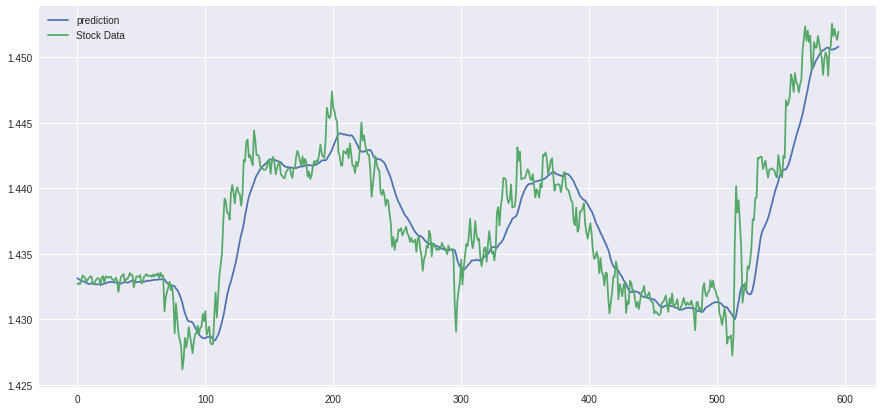

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(prediction_scaled_back, label='prediction')
plt.plot(target_scaled_back, label='Stock Data')
plt.legend()
plt.show()